In [1]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

# Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cpu")
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")

In [3]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)

            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_l2_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                print("\n", log)

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="l2loss")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [4]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder FC

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.2243402898311615, 'train_l2_loss': 5772.8876953125, 'train_kl_loss': 0.0}


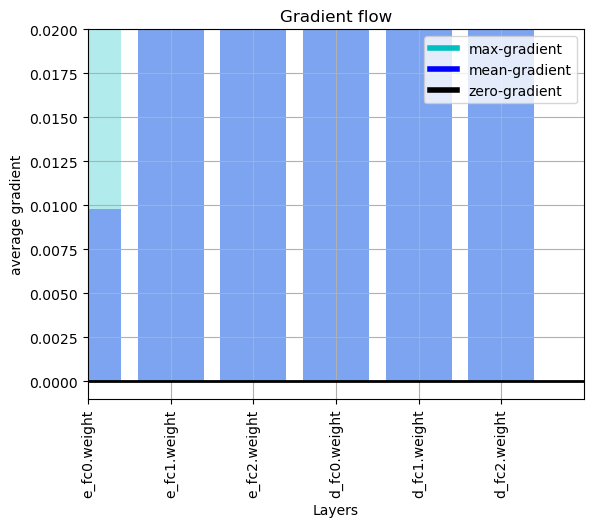

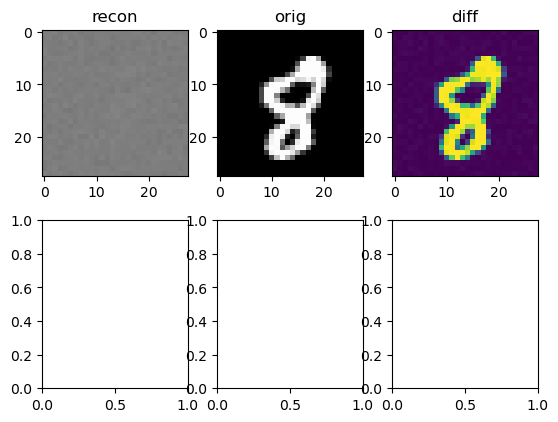

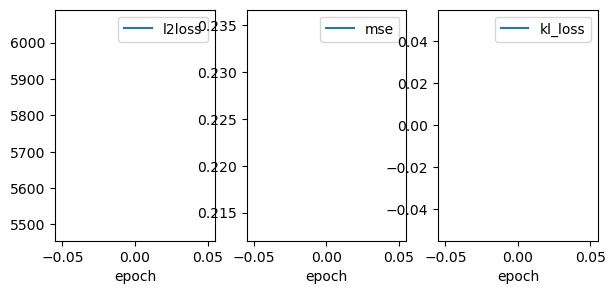

 20% (20 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:20


 {'epoch': 20, 'train_mse': 0.06430025398731232, 'train_l2_loss': 1622.656494140625, 'train_kl_loss': 0.0}


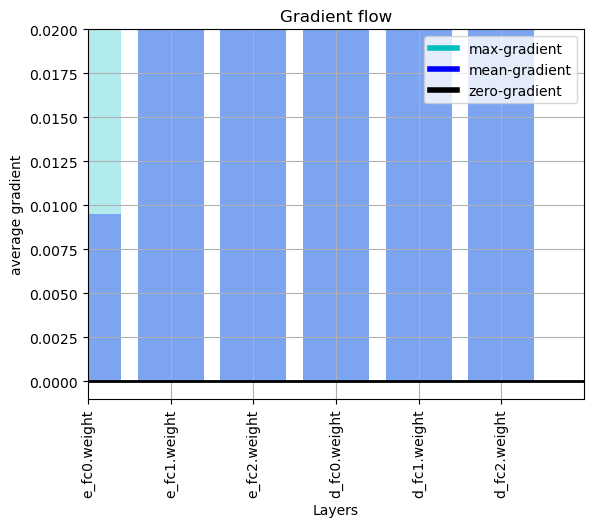

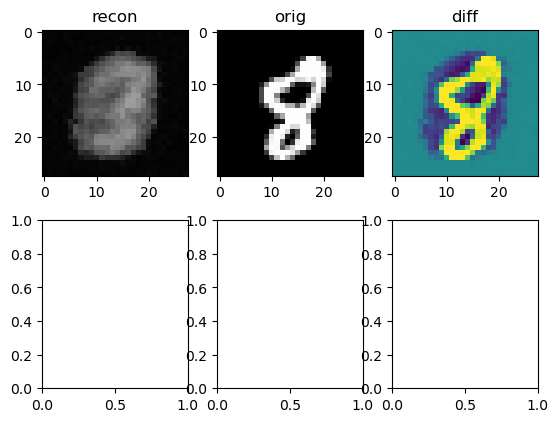

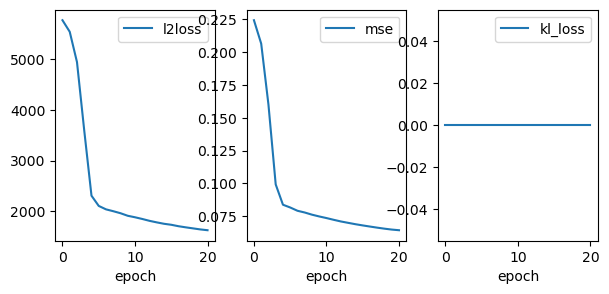

 40% (40 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:14


 {'epoch': 40, 'train_mse': 0.06031779199838638, 'train_l2_loss': 1520.4931640625, 'train_kl_loss': 0.0}


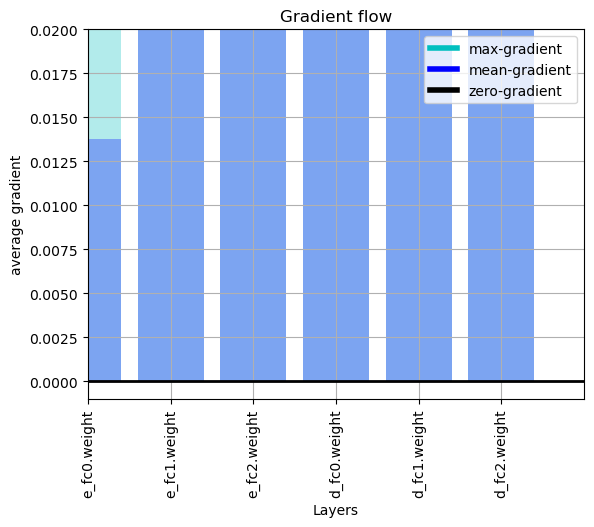

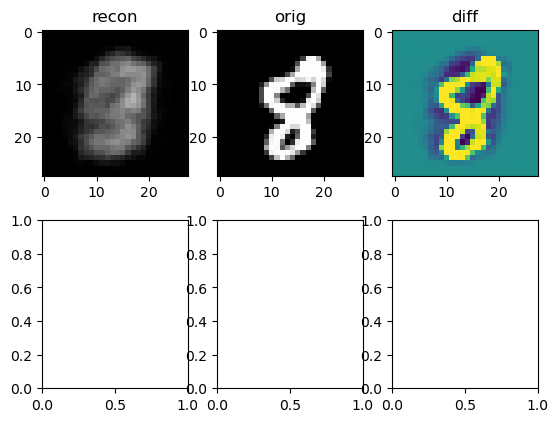

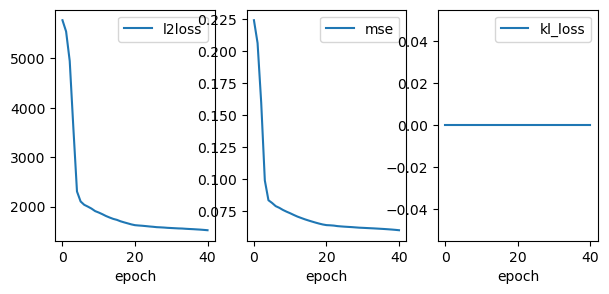

 60% (60 of 100) |#############          | Elapsed Time: 0:00:17 ETA:   0:00:10


 {'epoch': 60, 'train_mse': 0.047987475991249084, 'train_l2_loss': 1223.836181640625, 'train_kl_loss': 0.0}


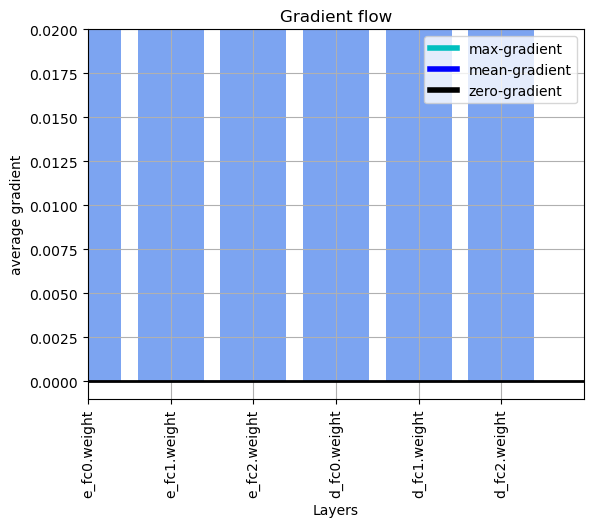

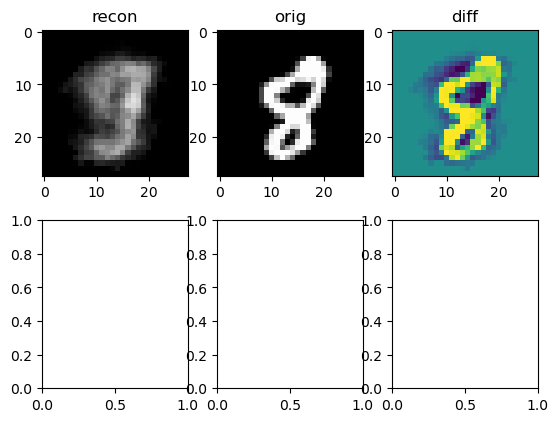

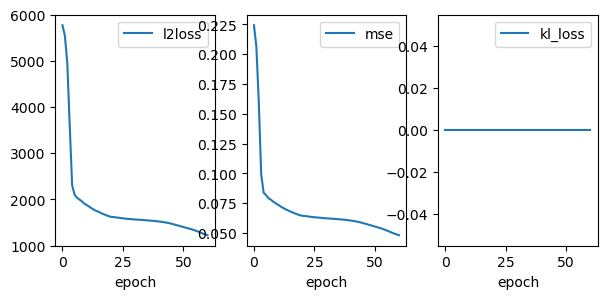

 80% (80 of 100) |##################     | Elapsed Time: 0:00:23 ETA:   0:00:05


 {'epoch': 80, 'train_mse': 0.032896239310503006, 'train_l2_loss': 841.3145141601562, 'train_kl_loss': 0.0}


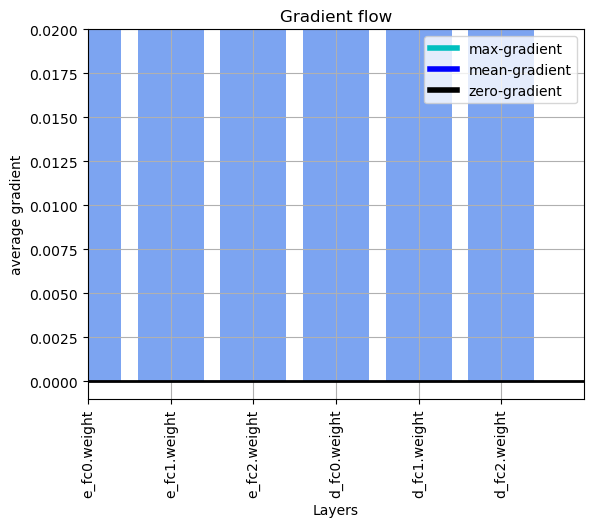

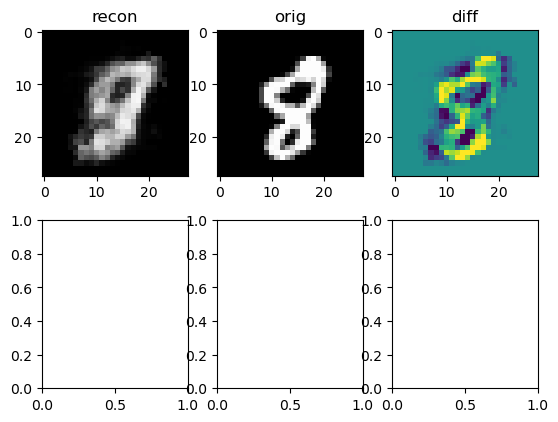

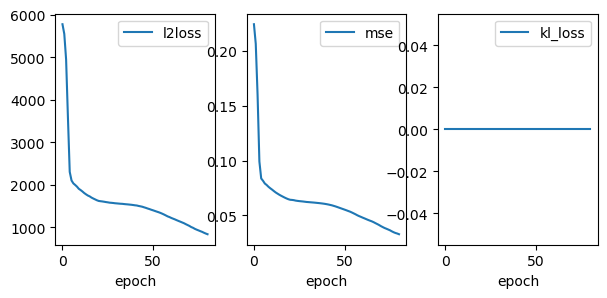

 99% (99 of 100) |###################### | Elapsed Time: 0:00:29 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.021407049149274826, 'train_l2_loss': 557.1558837890625, 'train_kl_loss': 0.0}


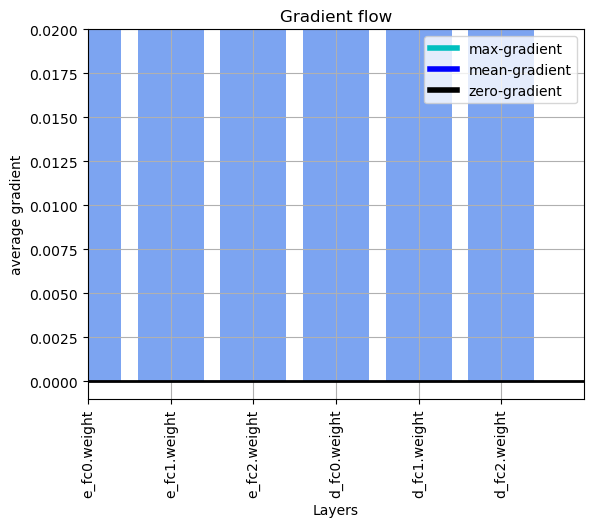

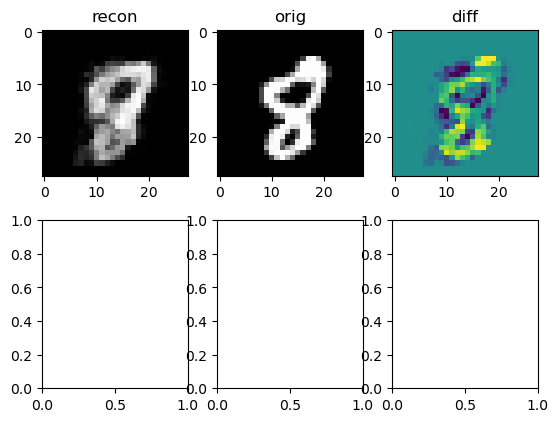

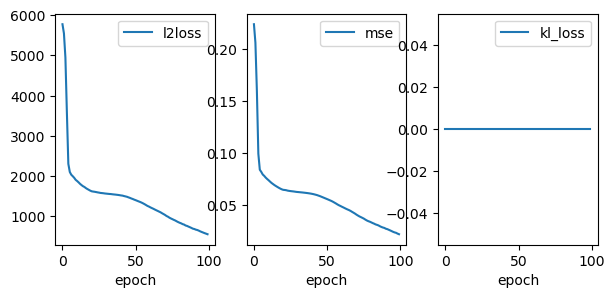

100% (100 of 100) |######################| Elapsed Time: 0:00:30 Time:  0:00:30


In [5]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


100% (625 of 625) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


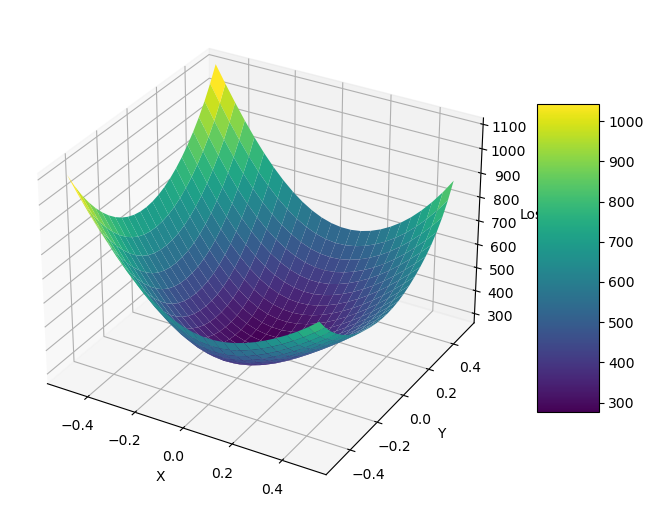

In [7]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, l2loss, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.22252850234508514, 'train_l2_loss': 5764.23876953125, 'train_kl_loss': 517.96435546875}


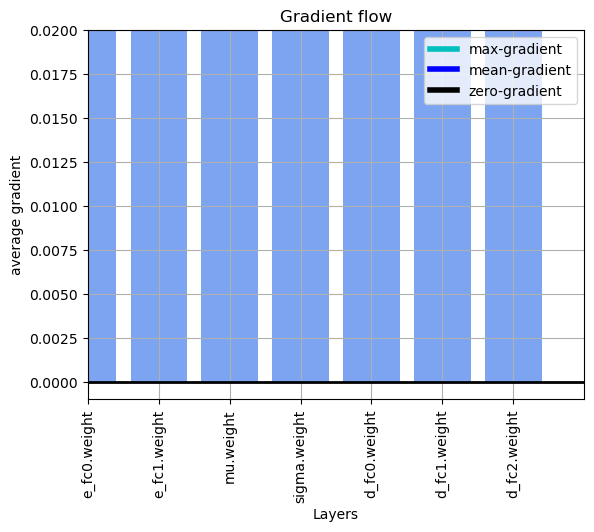

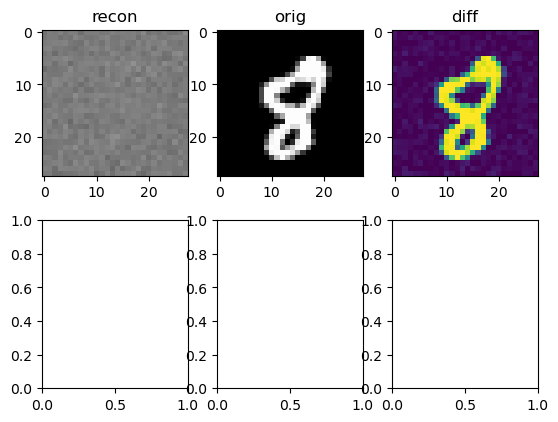

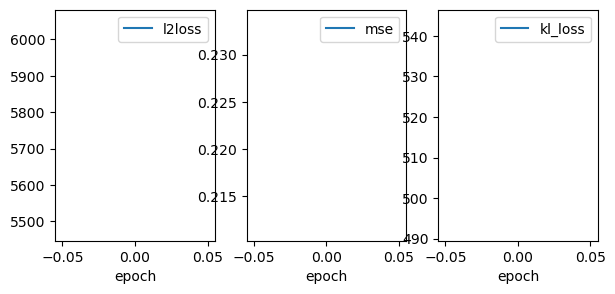

 20% (20 of 100) |####                   | Elapsed Time: 0:00:06 ETA:   0:00:22


 {'epoch': 20, 'train_mse': 0.07138562202453613, 'train_l2_loss': 1786.3863525390625, 'train_kl_loss': 560.204345703125}


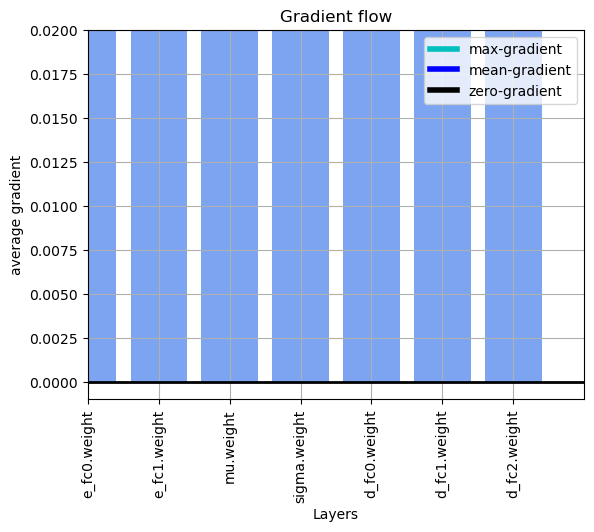

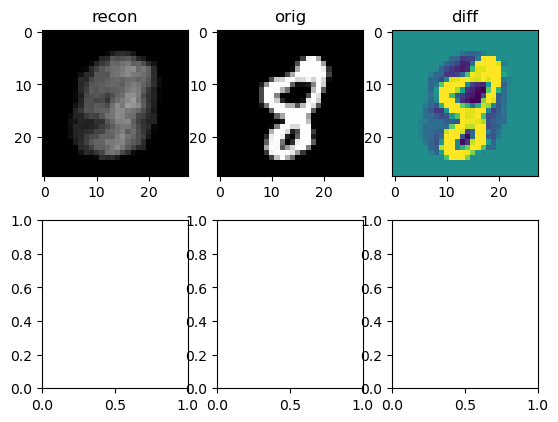

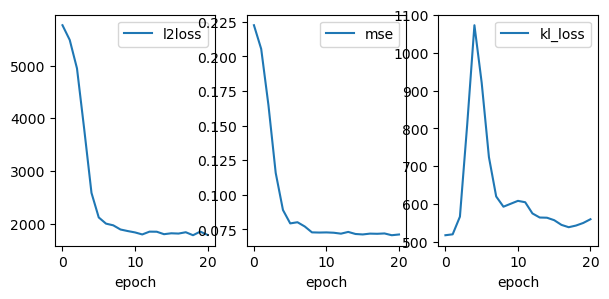

 40% (40 of 100) |#########              | Elapsed Time: 0:00:13 ETA:   0:00:16


 {'epoch': 40, 'train_mse': 0.06732971966266632, 'train_l2_loss': 1690.5494384765625, 'train_kl_loss': 552.5374755859375}


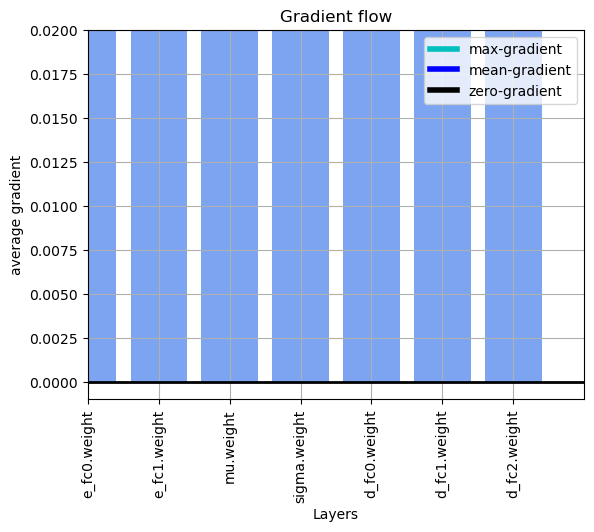

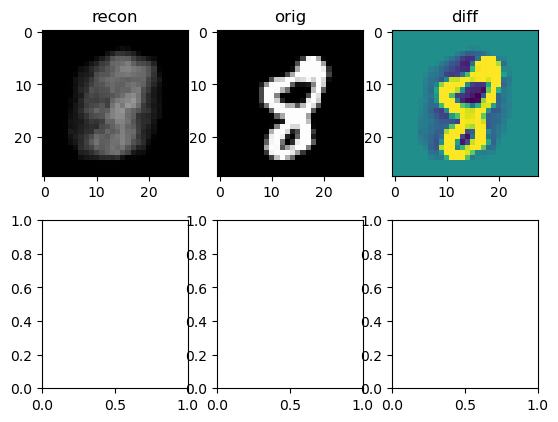

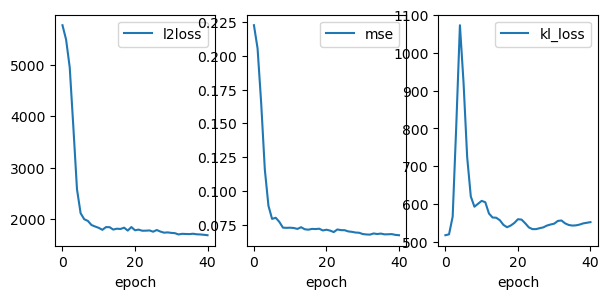

 60% (60 of 100) |#############          | Elapsed Time: 0:00:19 ETA:   0:00:11


 {'epoch': 60, 'train_mse': 0.0658525675535202, 'train_l2_loss': 1620.81396484375, 'train_kl_loss': 572.4785766601562}


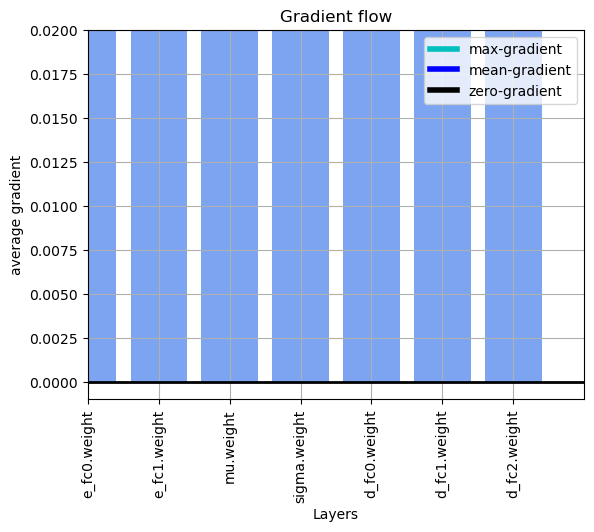

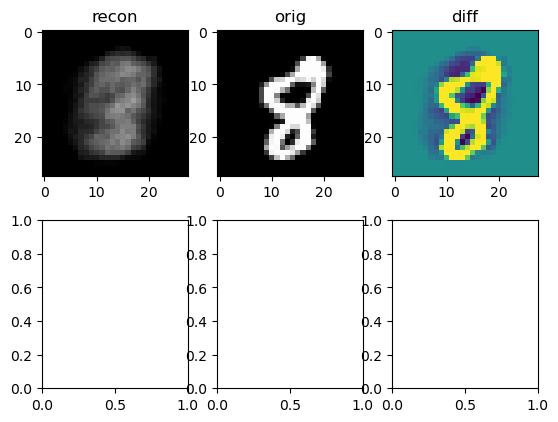

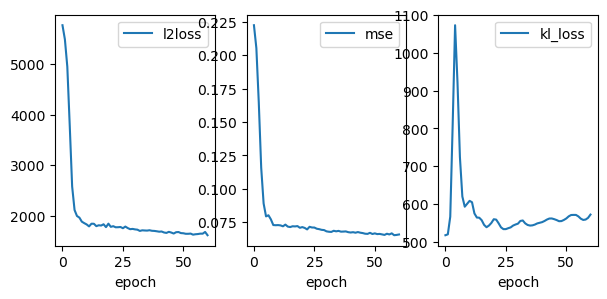

 80% (80 of 100) |##################     | Elapsed Time: 0:00:25 ETA:   0:00:05


 {'epoch': 80, 'train_mse': 0.06357979774475098, 'train_l2_loss': 1586.3707275390625, 'train_kl_loss': 594.5032958984375}


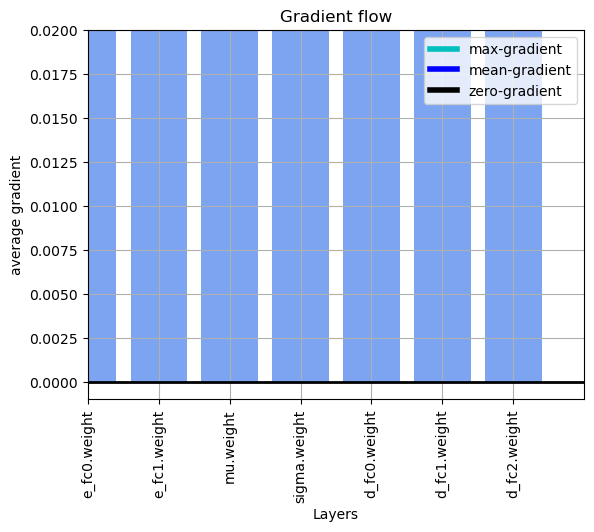

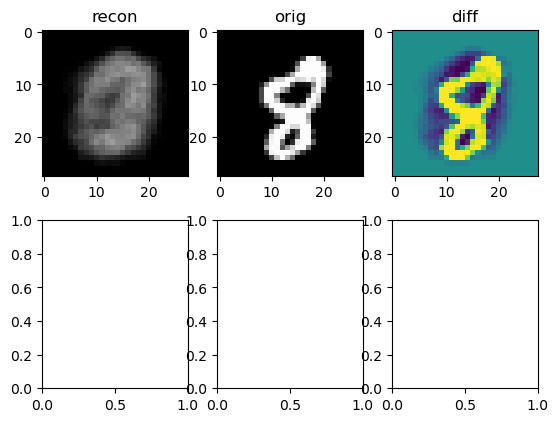

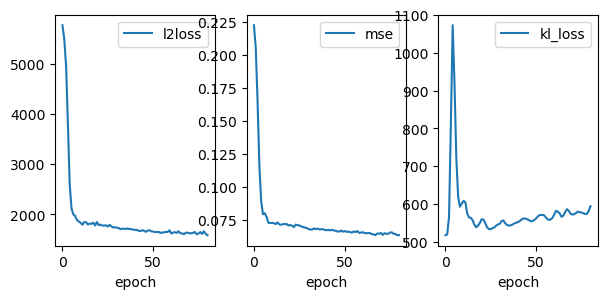

 99% (99 of 100) |###################### | Elapsed Time: 0:00:32 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.06160585582256317, 'train_l2_loss': 1556.002685546875, 'train_kl_loss': 605.768310546875}


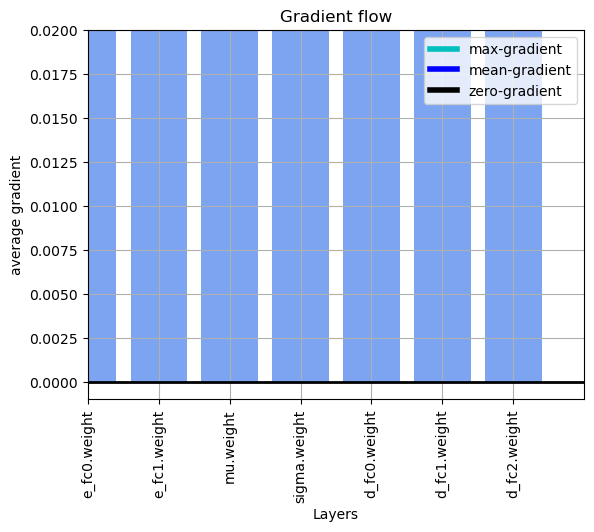

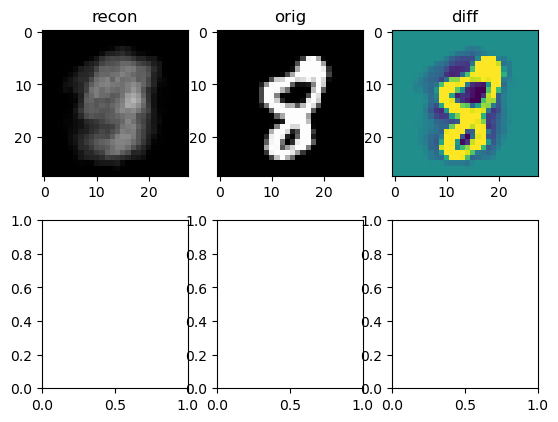

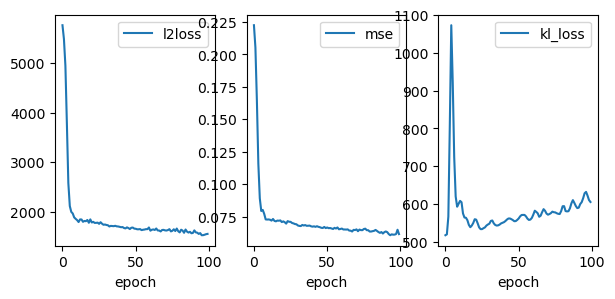

100% (100 of 100) |######################| Elapsed Time: 0:00:32 Time:  0:00:32


In [8]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.2107364535331726, 'train_l2_loss': 5312.49755859375, 'train_kl_loss': 0.0}


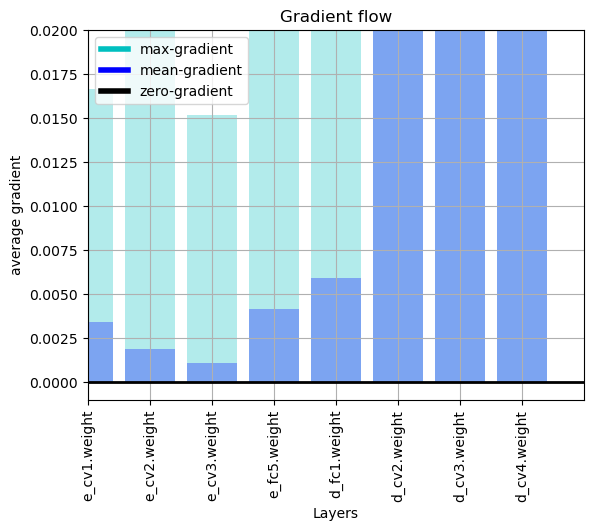

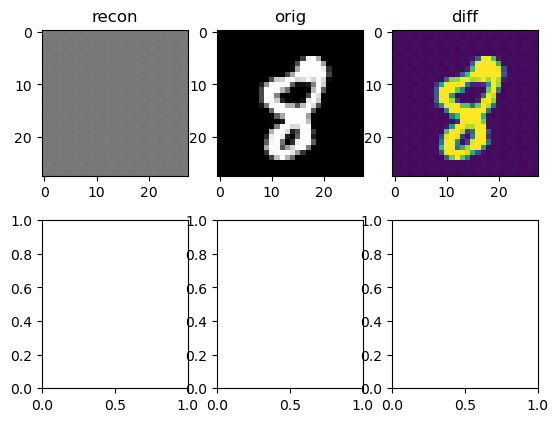

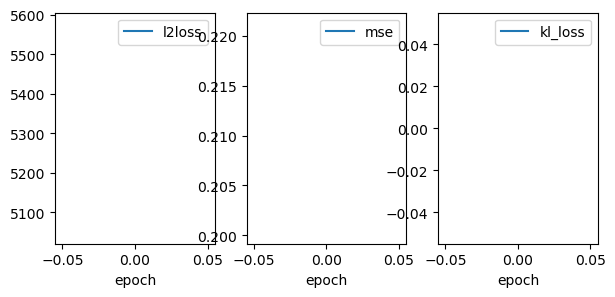

 20% (20 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:29


 {'epoch': 20, 'train_mse': 0.0771014392375946, 'train_l2_loss': 1949.278564453125, 'train_kl_loss': 0.0}


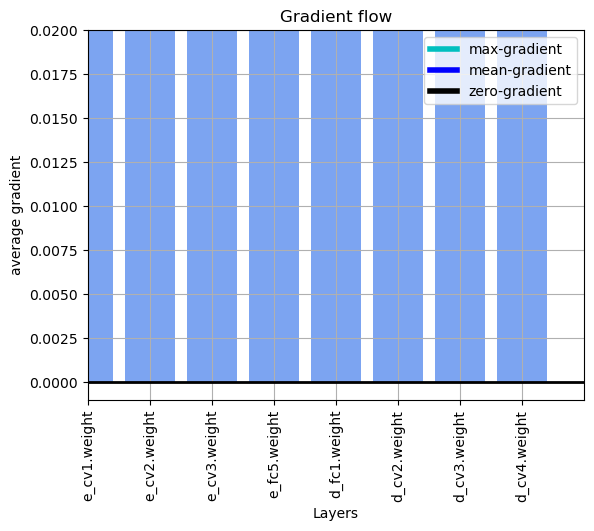

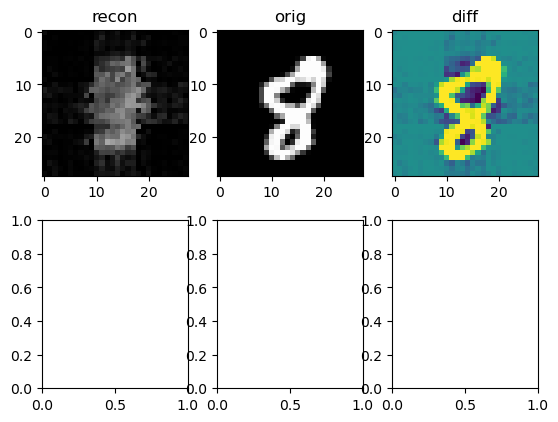

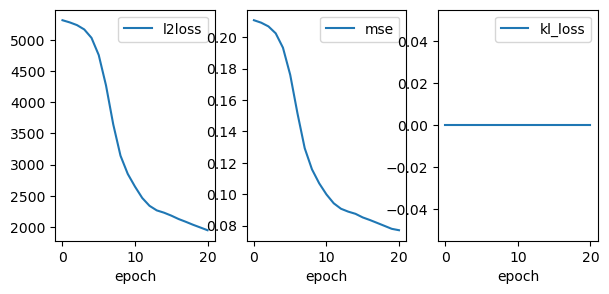

 40% (40 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:23


 {'epoch': 40, 'train_mse': 0.06279927492141724, 'train_l2_loss': 1578.967041015625, 'train_kl_loss': 0.0}


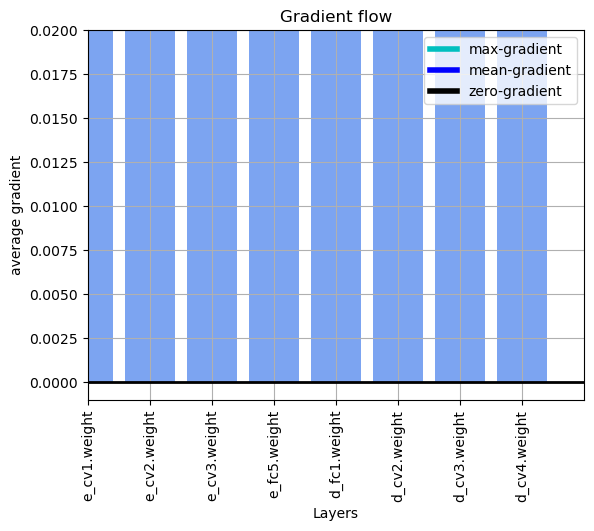

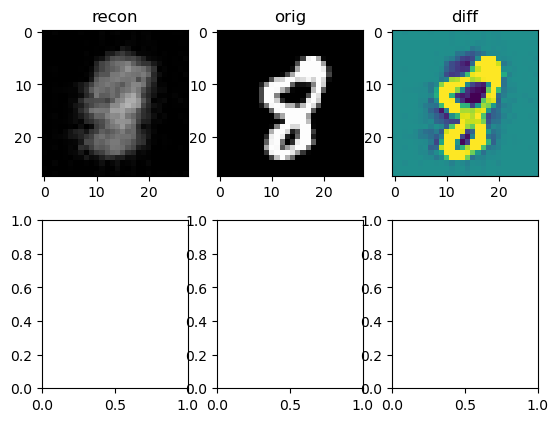

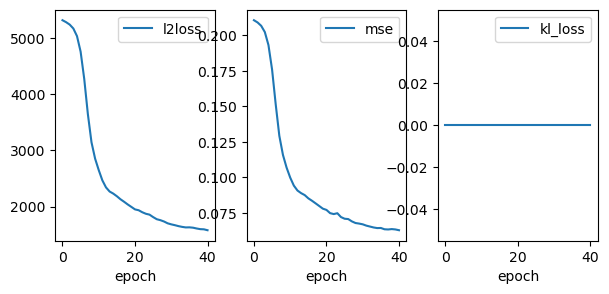

 60% (60 of 100) |#############          | Elapsed Time: 0:00:25 ETA:   0:00:14


 {'epoch': 60, 'train_mse': 0.0571674108505249, 'train_l2_loss': 1440.740234375, 'train_kl_loss': 0.0}


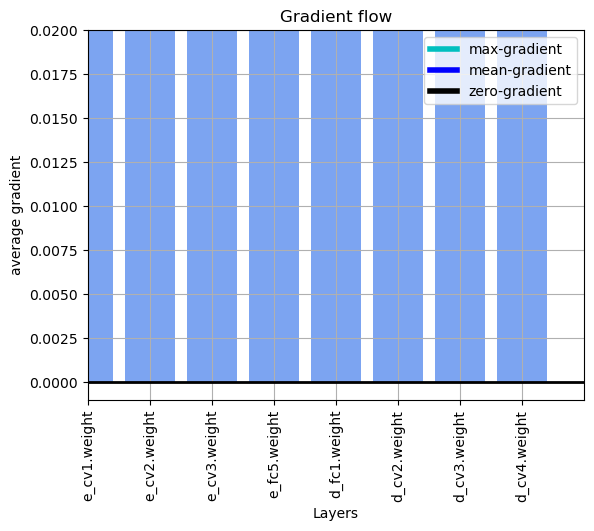

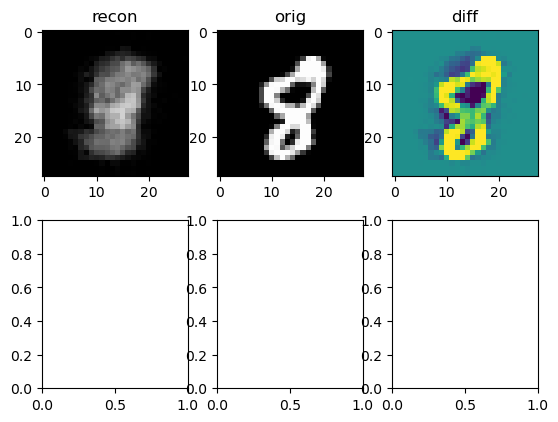

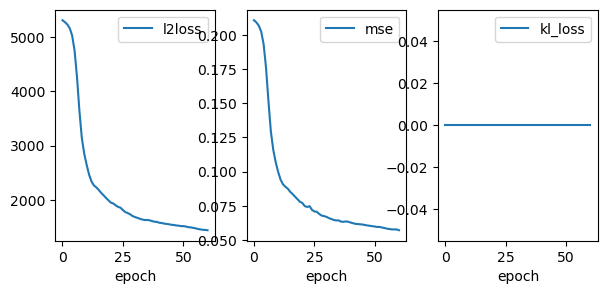

 80% (80 of 100) |##################     | Elapsed Time: 0:00:33 ETA:   0:00:08


 {'epoch': 80, 'train_mse': 0.049598775804042816, 'train_l2_loss': 1253.3177490234375, 'train_kl_loss': 0.0}


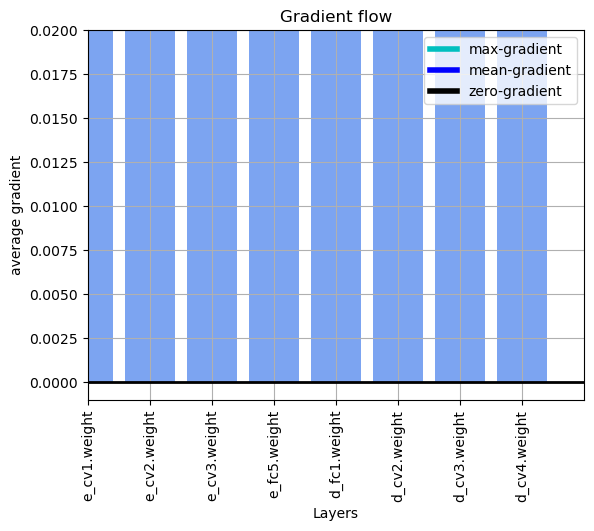

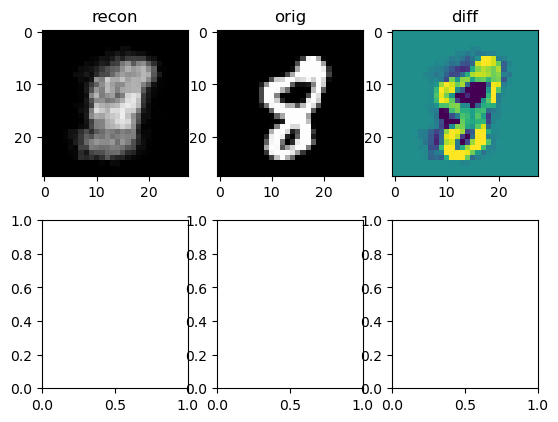

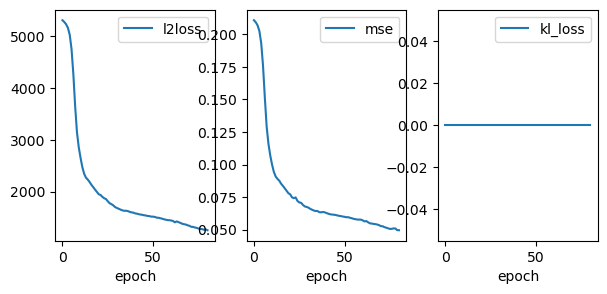

 99% (99 of 100) |###################### | Elapsed Time: 0:00:42 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.04427724331617355, 'train_l2_loss': 1108.82568359375, 'train_kl_loss': 0.0}


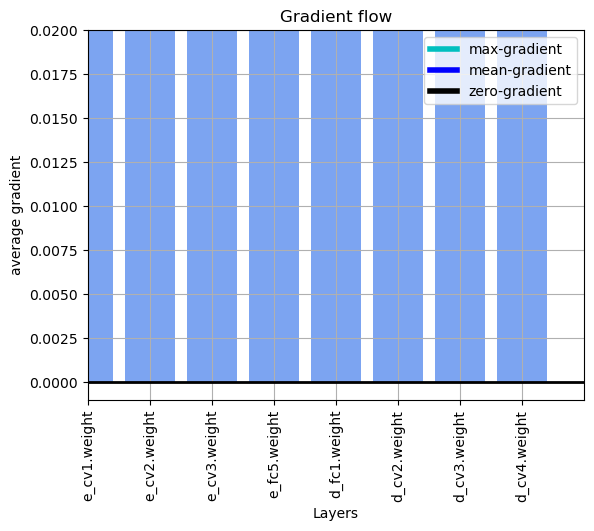

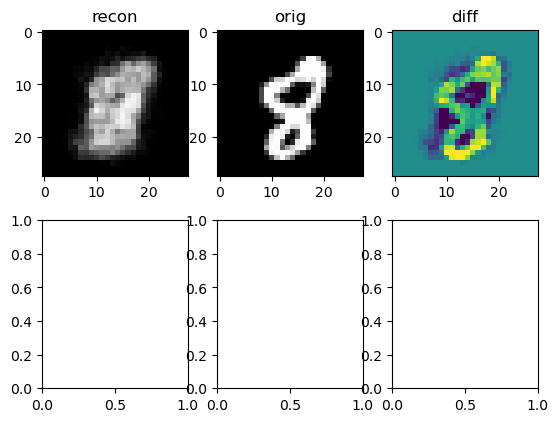

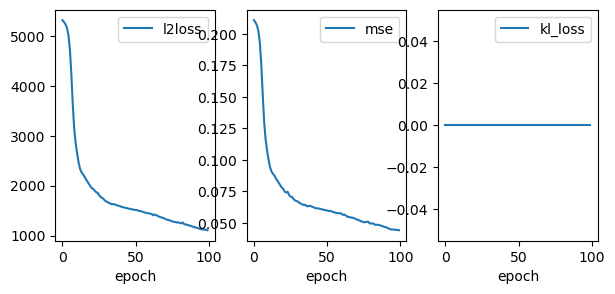

100% (100 of 100) |######################| Elapsed Time: 0:00:42 Time:  0:00:42


In [9]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.24221757054328918, 'train_l2_loss': 6114.205078125, 'train_kl_loss': 518.8937377929688}


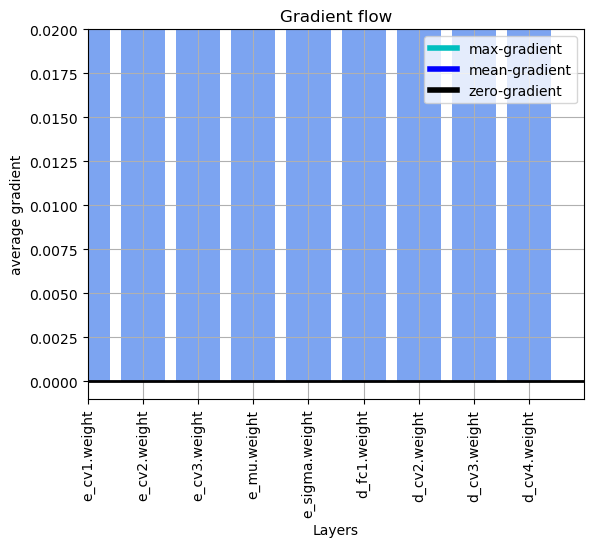

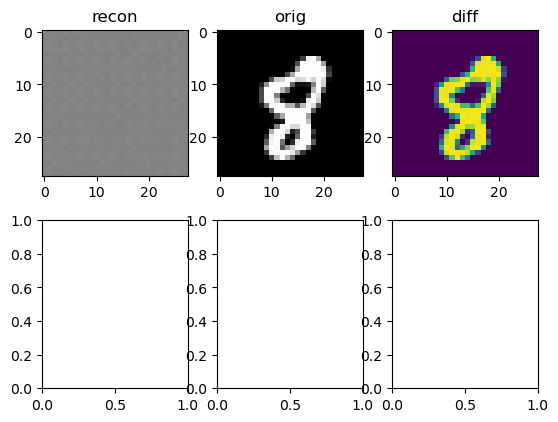

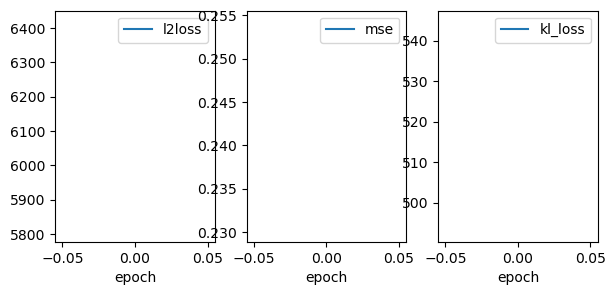

 20% (20 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:32


 {'epoch': 20, 'train_mse': 0.09090079367160797, 'train_l2_loss': 2289.197265625, 'train_kl_loss': 638.5736083984375}


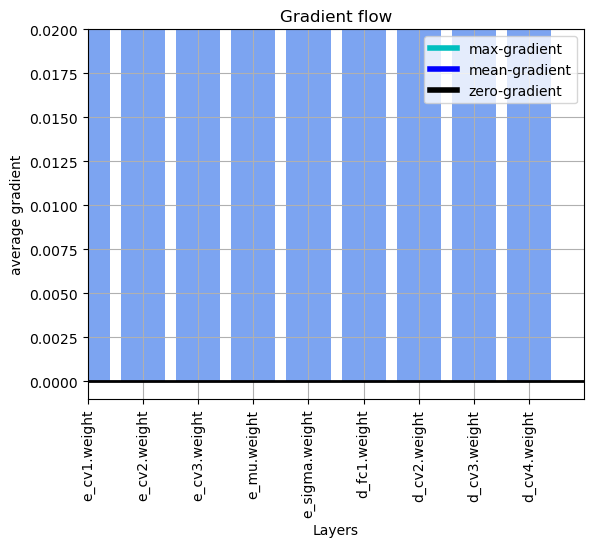

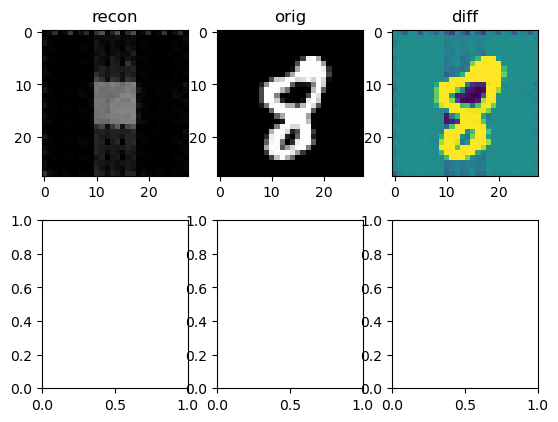

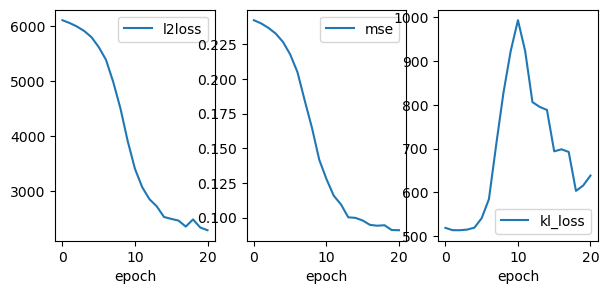

 40% (40 of 100) |#########              | Elapsed Time: 0:00:17 ETA:   0:00:24


 {'epoch': 40, 'train_mse': 0.08174528181552887, 'train_l2_loss': 2048.695068359375, 'train_kl_loss': 604.9263916015625}


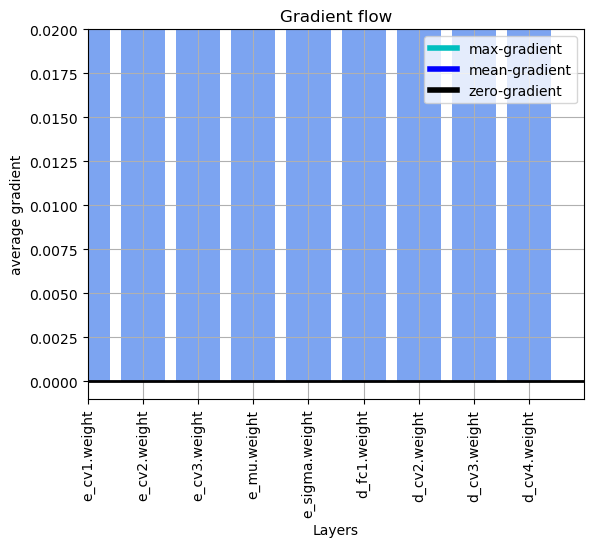

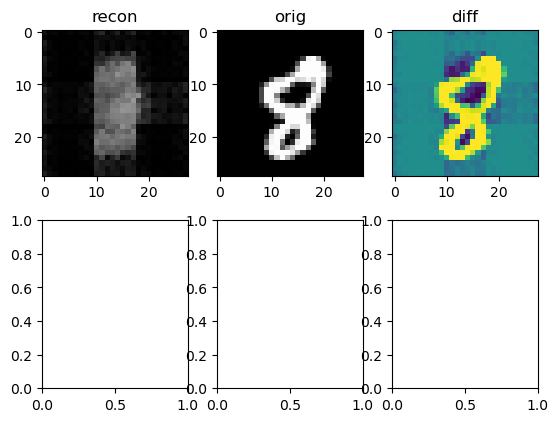

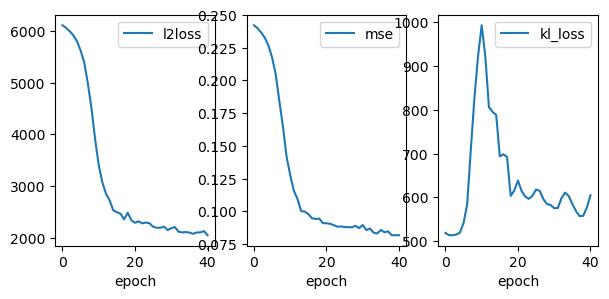

 60% (60 of 100) |#############          | Elapsed Time: 0:00:27 ETA:   0:00:16


 {'epoch': 60, 'train_mse': 0.07519508898258209, 'train_l2_loss': 1881.714111328125, 'train_kl_loss': 561.5680541992188}


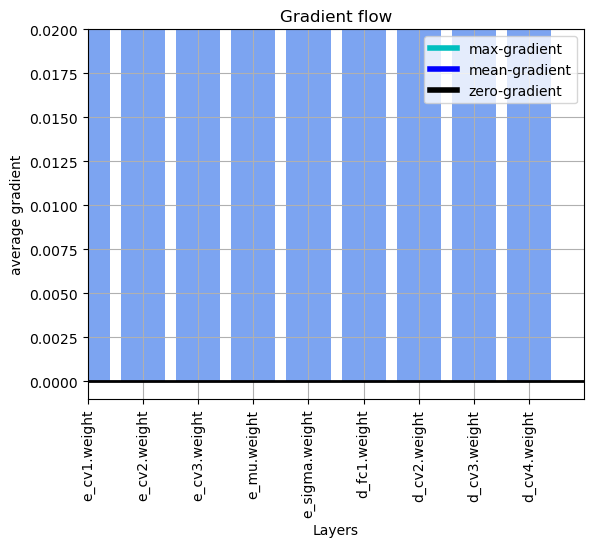

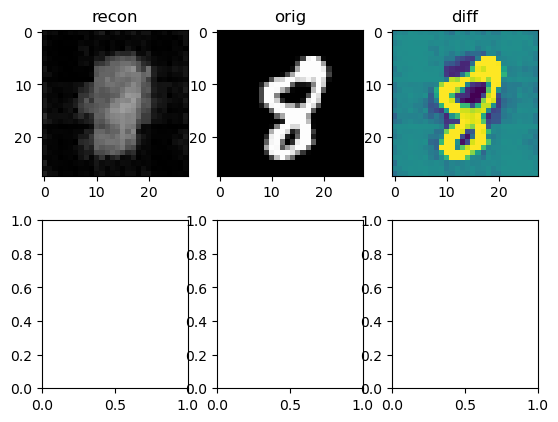

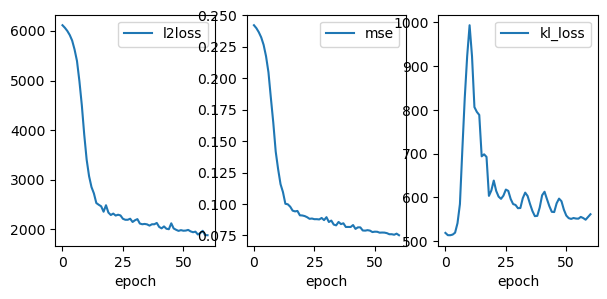

 80% (80 of 100) |##################     | Elapsed Time: 0:00:36 ETA:   0:00:08


 {'epoch': 80, 'train_mse': 0.0701555535197258, 'train_l2_loss': 1774.69677734375, 'train_kl_loss': 545.5474243164062}


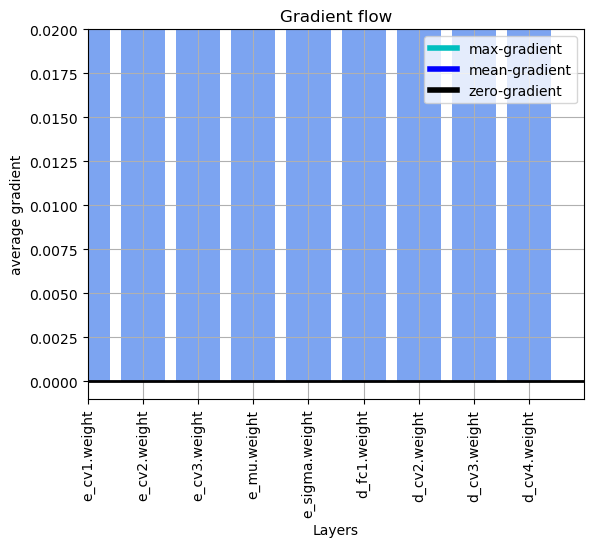

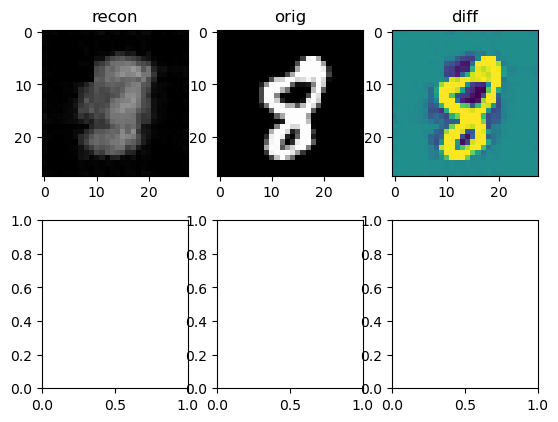

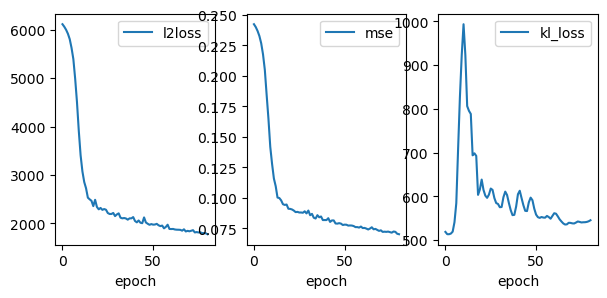

 99% (99 of 100) |###################### | Elapsed Time: 0:00:44 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.06689684092998505, 'train_l2_loss': 1686.910400390625, 'train_kl_loss': 569.2100219726562}


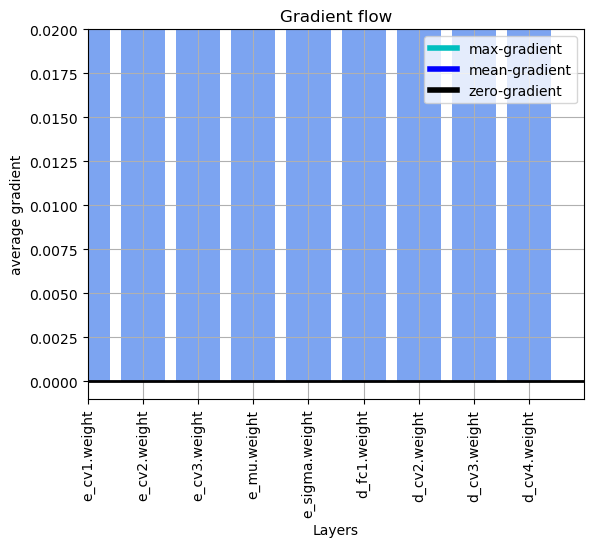

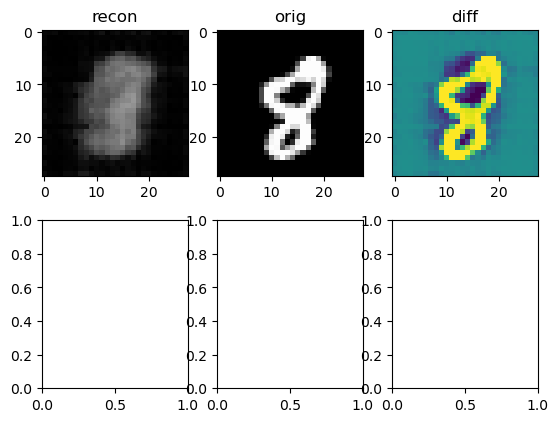

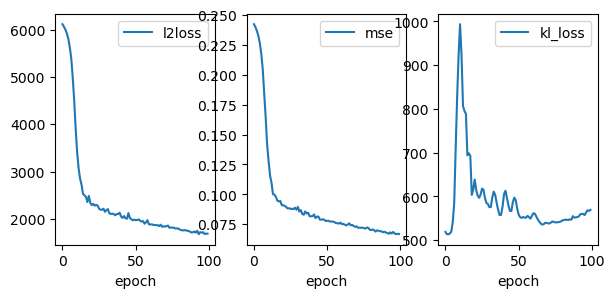

100% (100 of 100) |######################| Elapsed Time: 0:00:45 Time:  0:00:45


In [10]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)